<H1 style="text-align: center">ECMM426 - Computer Vision</H1>
<H1 style="text-align: center">Workshop 3</H1>
<H1 style="text-align: center">Feature Description and Matching</H1>

## Imports

In [1]:
import os
import math
import urllib
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_peaks
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 72

# install and then import opencv
!pip3 install opencv-python==4.4.0.42
import cv2
print('OpenCV version: {}'.format(cv2.__version__))

C:\Users\hadee\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [2007 lines of output]
  Ignoring numpy: markers 'python_version == "3.5"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7"' don't match your environment
    Using cached setuptools-69.0.3-py3-none-any.whl.metadata (6.3 kB)
    Using cached wheel-0.42.0-py3-none-any.whl.metadata (2.2 kB)
    Using cached scikit_build-0.17.6-py3-none-any.whl.metadata (14 kB)
    Using cached cmake-3.28.1-py2.py3-none-win_amd64.whl.metadata (6.5 kB)
    Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
    Using cached numpy-1.17.3.zip (6.4 MB)
    Preparing metadata (setup.py): started
    Pre

  Using cached opencv-python-4.4.0.42.tar.gz (88.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


ModuleNotFoundError: No module named 'cv2'

In [17]:
if not os.path.exists('paired_data.zip'):
    !wget --no-check-certificate https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/paired_data.zip
    !unzip -q paired_data.zip

In [2]:
pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


## Utils
Some useful functions that we are going to use this workshop.

In [40]:
import pickle
def im2single(im):
    im = im.astype(np.float32) / 255
    return im

def single2im(im):
    im *= 255
    im = im.astype(np.uint8)
    return im

def cheat_interest_points(eval_file, scale_factor):
    """
    This function is provided for development and debugging but cannot be used in
    the final handin. It 'cheats' by generating interest points from known
    correspondences. It will only work for the 3 image pairs with known
    correspondences.

    Args:
    - eval_file: string representing the file path to the list of known correspondences
    - scale_factor: Python float representing the scale needed to map from the original
            image coordinates to the resolution being used for the current experiment.

    Returns:
    - x1: A numpy array of shape (k,) containing ground truth x-coordinates of imgA correspondence pts
    - y1: A numpy array of shape (k,) containing ground truth y-coordinates of imgA correspondence pts
    - x2: A numpy array of shape (k,) containing ground truth x-coordinates of imgB correspondence pts
    - y2: A numpy array of shape (k,) containing ground truth y-coordinates of imgB correspondence pts
    """
    with open(eval_file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')

    return d['x1'] * scale_factor, d['y1'] * scale_factor, d['x2'] * scale_factor,\
                    d['y2'] * scale_factor

def show_interest_points(img, X, Y):
    """
    Visualized interest points on an image with random colors

    Args:
    - img: A numpy array of shape (M,N,C)
    - X: A numpy array of shape (k,) containing x-locations of interest points
    - Y: A numpy array of shape (k,) containing y-locations of interest points

    Returns:
    - newImg: A numpy array of shape (M,N,C) showing the original image with
            colored circles at keypoints plotted on top of it
    """
    radius_circle = 20
    newImg = img.copy()
    for x, y in zip(X.astype(int), Y.astype(int)):
        cur_color = np.random.rand(3)
        newImg = cv2.circle(newImg, (int(x), int(y)), radius_circle, cur_color, -1, cv2.LINE_AA)
    return newImg

def show_correspondence_circles(imgA, imgB, X1, Y1, X2, Y2):
    """
    Visualizes corresponding points between two images by plotting circles at
    each correspondence location. Corresponding points will have the same random color.

    Args:
    - imgA: A numpy array of shape (M,N,3)
    - imgB: A numpy array of shape (D,E,3)
    - x1: A numpy array of shape (k,) containing x-locations of keypoints in imgA
    - y1: A numpy array of shape (k,) containing y-locations of keypoints in imgA
    - x2: A numpy array of shape (j,) containing x-locations of keypoints in imgB
    - y2: A numpy array of shape (j,) containing y-locations of keypoints in imgB

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    radius_circle = 20
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(int)
    Y1 = Y1.astype(int)
    X2 = X2.astype(int)
    Y2 = Y2.astype(int)

    for x1, y1, x2, y2 in zip(X1, Y1, X2, Y2):
        cur_color = np.random.rand(3)
        green = (0, 1, 0)
        newImg = cv2.circle(newImg, (x1, y1), radius_circle, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x1, y1), radius_circle, green, 2, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), radius_circle, cur_color, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), radius_circle, green, 2, cv2.LINE_AA)

    return newImg

def show_correspondence_lines(imgA, imgB, X1, Y1, X2, Y2, line_colors=None):
    """
    Visualizes corresponding points between two images by drawing a line segment
    between the two images for each (x1,y1) (x2,y2) pair.

    Args:
    - imgA: A numpy array of shape (M,N,3)
    - imgB: A numpy array of shape (D,E,3)
    - x1: A numpy array of shape (k,) containing x-locations of keypoints in imgA
    - y1: A numpy array of shape (k,) containing y-locations of keypoints in imgA
    - x2: A numpy array of shape (j,) containing x-locations of keypoints in imgB
    - y2: A numpy array of shape (j,) containing y-locations of keypoints in imgB
    - line_colors: A numpy array of shape (N x 3) with colors of correspondence lines (optional)

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    radius_circle = 20
    newImg = hstack_images(imgA, imgB)
    shiftX = imgA.shape[1]
    X1 = X1.astype(int)
    Y1 = Y1.astype(int)
    X2 = X2.astype(int)
    Y2 = Y2.astype(int)

    dot_colors = np.random.rand(len(X1), 3)
    if line_colors is None:
        line_colors = dot_colors

    for x1, y1, x2, y2, dot_color, line_color in zip(X1, Y1, X2, Y2, dot_colors, line_colors):
        newImg = cv2.circle(newImg, (x1, y1), radius_circle, dot_color, -1)
        newImg = cv2.circle(newImg, (x2+shiftX, y2), radius_circle, dot_color, -1)
        newImg = cv2.line(newImg, (x1, y1), (x2+shiftX, y2), line_color, 2, cv2.LINE_AA)
    return newImg

def hstack_images(imgA, imgB):
    """
    Stacks 2 images side-by-side and creates one combined image.

    Args:
    - imgA: A numpy array of shape (M,N,3) representing rgb image
    - imgB: A numpy array of shape (D,E,3) representing rgb image

    Returns:
    - newImg: A numpy array of shape (max(M,D), N+E, 3)
    """
    Height = max(imgA.shape[0], imgB.shape[0])
    Width  = imgA.shape[1] + imgB.shape[1]

    newImg = np.zeros((Height, Width, 3), dtype=imgA.dtype)
    newImg[:imgA.shape[0], :imgA.shape[1], :] = imgA
    newImg[:imgB.shape[0], imgA.shape[1]:, :] = imgB

    return newImg

def evaluate_correspondence(imgA, imgB, corr_fpath, scale_factor, x1_est, y1_est,
        x2_est, y2_est, confidences=None, num_req_matches=100):
    """
    Function to evaluate estimated correspondences against ground truth.

    The evaluation requires 100 matches to receive full credit
    when num_req_matches=100 because we define accuracy as:

    Accuracy = (true_pos)/(true_pos+false_pos) * min(num_matches,num_req_matches)/num_req_matches

    Args:
    - imgA: A numpy array of shape (M,N,C) representing a first image
    - imgB: A numpy array of shape (M,N,C) representing a second image
    - corr_fpath: string, representing a filepath to a .pkl file containing ground truth correspondences
    - scale_factor: scale factor on the size of the images
    - x1_est: A numpy array of shape (k,) containing estimated x-coordinates of imgA correspondence pts
    - y1_est: A numpy array of shape (k,) containing estimated y-coordinates of imgA correspondence pts
    - x2_est: A numpy array of shape (k,) containing estimated x-coordinates of imgB correspondence pts
    - y2_est: A numpy array of shape (k,) containing estimated y-coordinates of imgB correspondence pts
    - confidences: (optional) confidence values in the matches
    """
    if confidences is None:
        confidences = np.random.rand(len(x1_est))
        confidences /= np.max(confidences)

    x1_est = x1_est.squeeze() / scale_factor
    y1_est = y1_est.squeeze() / scale_factor
    x2_est = x2_est.squeeze() / scale_factor
    y2_est = y2_est.squeeze() / scale_factor

    num_matches = x1_est.shape[0]

    x1,y1,x2,y2 = load_corr_pkl_file(corr_fpath)

    good_matches = [False for _ in range(len(x1_est))]
    # array marking which GT pairs are already matched
    matched = [False for _ in range(len(x1))]

    # iterate through estimated pairs in decreasing order of confidence
    priority = np.argsort(-confidences)
    for i in priority:
        # print('Examining ({:4.0f}, {:4.0f}) to ({:4.0f}, {:4.0f})'.format(
        #     x1_est[i], y1_est[i], x2_est[i], y2_est[i]))
        cur_offset = np.asarray([x1_est[i]-x2_est[i], y1_est[i]-y2_est[i]])
        # for each x1_est find nearest ground truth point in x1
        dists = np.linalg.norm(np.vstack((x1_est[i]-x1, y1_est[i]-y1)), axis=0)
        best_matches = np.argsort(dists)

        # find the best match that is not taken yet
        for match_idx in best_matches:
            if not matched[match_idx]:
                break
        else:
            continue

        # A match is good only if
        # (1) An unmatched GT point exists within 150 pixels, and
        # (2) GT correspondence offset is within 25 pixels of estimated
        #     correspondence offset
        gt_offset = np.asarray([x1[match_idx]-x2[match_idx],
            y1[match_idx]-y2[match_idx]])
        offset_dist = np.linalg.norm(cur_offset-gt_offset)
        if (dists[match_idx] < 150.0) and (offset_dist < 25):
            good_matches[i] = True
            print('Correct')
        else:
            print('Incorrect')

    print('You found {}/{} required matches'.format(num_matches, num_req_matches))
    accuracy = np.mean(good_matches) * min(num_matches, num_req_matches)*1./num_req_matches
    print('Accuracy = {:f}'.format(accuracy))
    green = np.asarray([0, 1, 0], dtype=float)
    red = np.asarray([1, 0, 0], dtype=float)
    line_colors = np.asarray([green if m else red for m in good_matches])

    return accuracy, show_correspondence_lines(imgA, imgB,
                                               x1_est*scale_factor, y1_est*scale_factor,
                                               x2_est*scale_factor, y2_est*scale_factor,
                                               line_colors)

def load_corr_pkl_file(corr_fpath):
    """ 
    Load ground truth correspondences from a pickle (.pkl) file. 
    """
    with open(corr_fpath, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
    x1 = d['x1'].squeeze()
    y1 = d['y1'].squeeze()
    x2 = d['x2'].squeeze()
    y2 = d['y2'].squeeze()

    return x1,y1,x2,y2

## Get some paired data

### Notre Dame

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3598878025.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  newImg = cv2.circle(newImg, (int(x), int(y)), radius_circle, cur_color, -1, cv2.LINE_AA)


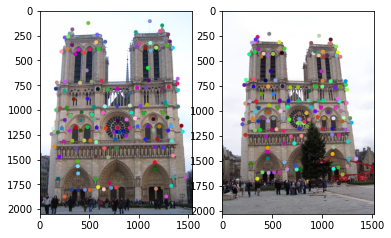

In [41]:
scale_factor = 1.0
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/921919841_a30df938f2_o.jpg'), cv2.COLOR_BGR2RGB))
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/4191453057_c86028ce1f_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
eval_file = 'paired_data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(img1, x1, y1)
c2 = show_interest_points(img2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1)
plt.subplot(1, 2, 2), plt.imshow(c2)
plt.show()

### Mount Rushmore

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3598878025.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  newImg = cv2.circle(newImg, (int(x), int(y)), radius_circle, cur_color, -1, cv2.LINE_AA)


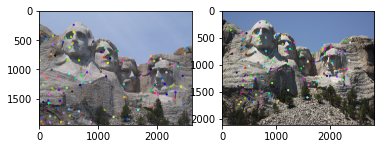

In [42]:
scale_factor = 1.0
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9021235130_7c2acd9554_o.jpg'), cv2.COLOR_BGR2RGB))
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9318872612_a255c874fb_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
eval_file = 'paired_data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(img1, x1, y1)
c2 = show_interest_points(img2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1)
plt.subplot(1, 2, 2), plt.imshow(c2)
plt.show()

### Episcopal Gaudi

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3598878025.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  newImg = cv2.circle(newImg, (int(x), int(y)), radius_circle, cur_color, -1, cv2.LINE_AA)


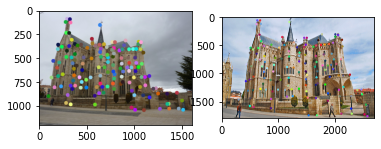

In [43]:
scale_factor = 1.0
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg'), cv2.COLOR_BGR2RGB))
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
eval_file = 'paired_data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
c1 = show_interest_points(img1, x1, y1)
c2 = show_interest_points(img2, x2, y2)
plt.subplot(1, 2, 1), plt.imshow(c1)
plt.subplot(1, 2, 2), plt.imshow(c2)
plt.show()

## `NormalizedPatchFeatures` function

In [44]:
def NormalizedPatchFeatures(img, x, y, feature_width=16, scales=None):
    assert img.ndim == 2, 'Image must be grayscale'

    # Gaussian smoothing
    img = cv2.GaussianBlur(img, (3, 3), 2)

    # allocate memory
    features = np.zeros((x.shape[0], feature_width**2))
    
    # half of feature width
    win_rng = feature_width // 2

    # go through each key point
    for i in range(x.shape[0]):
        xi = int(x[i])
        yi = int(y[i])
        # get patch
        patch = img[yi - win_rng : yi + win_rng, xi - win_rng : xi + win_rng]
        features[i, :] = patch.flatten()
    features = features**0.5
    return features

## Matching with ratio criteria

In [45]:
from sklearn.metrics.pairwise import euclidean_distances
def MatchFeatures(features1, features2, x1, y1, x2, y2, threshold=0.75):

    # euclidean distances
    distances = euclidean_distances(features1, features2)

    # sorted distances
    indices = np.argsort(distances, axis=1)
    sorted_distances = np.take_along_axis(distances, indices, axis=1)

    # NNDR
    scores = sorted_distances[:, 0] / sorted_distances[:, 1]

    # where scores < threshold
    idx = scores < threshold

    # confidence
    confidences = 1 / scores[idx]

    k = confidences.shape[0]
    matches = np.zeros((k, 2), dtype=int)
    
    # matches for which we have score or distance < threshold
    matches[:, 0] = np.where(idx)[0]
    matches[:, 1] = indices[idx, 0]

    # arrange the matches and the confidences in descending order
    idx = (-confidences).argsort()
    matches = matches[idx, :]
    confidences = confidences[idx]

    return matches, confidences

## Notre Dame

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi = int(x[i])
/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = int(y[i])


108 matches from 149 corners
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Correct
Correct
Correct
Incorrect
Correct
Incorrect
Incorrect
Correct
Correct
Correct
Correct
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Correct
Correct
Incorrect
Correct
Correct
Correct
Correct
Incorrect
Correct
Correct
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Correct
Incorrect
Correct
Correct
Incorrect
Incorrect
Correct
Correct
Correct
Correct
Correct
Correct
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Correct
Correct
Incorrect
Correct
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Correct
Correct
Correct
Correct
Incorrect
Correct
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Correct
Incorrect
You found 100/100 required matches
Accuracy = 0.460000


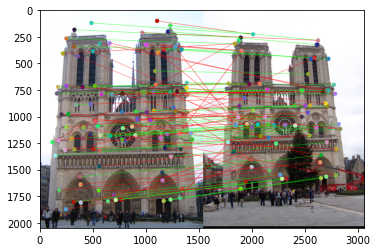

In [46]:
scale_factor = 1.0
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/921919841_a30df938f2_o.jpg'), cv2.COLOR_BGR2RGB))
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Notre Dame/4191453057_c86028ce1f_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
eval_file = 'paired_data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img1_feats = NormalizedPatchFeatures(gray_img1, x1, y1)
img2_feats = NormalizedPatchFeatures(gray_img2, x2, y2)
matches, confidences = MatchFeatures(img1_feats, img2_feats, x1, y1, x2, y2, threshold=0.95)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(img1, img2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.show()

## Mount Rushmore

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi = int(x[i])
/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = int(y[i])


126 matches from 126 corners
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Correct
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Inc

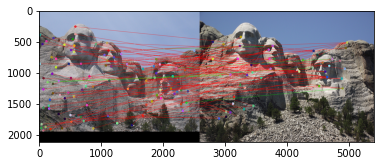

In [47]:
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9021235130_7c2acd9554_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Mount Rushmore/9318872612_a255c874fb_o.jpg'), cv2.COLOR_BGR2RGB))
eval_file = 'paired_data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img1_feats = NormalizedPatchFeatures(gray_img1, x1, y1)
img2_feats = NormalizedPatchFeatures(gray_img2, x2, y2)
matches, confidences = MatchFeatures(img1_feats, img2_feats, x1, y1, x2, y2, threshold=1.0)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(img1, img2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.show()

## Episcopal Gaudi

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi = int(x[i])
/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/3821415889.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = int(y[i])


146 matches from 146 corners
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Correct
Incorrect
Incorrect
Incorrect
Incorrect
Incorrect
I

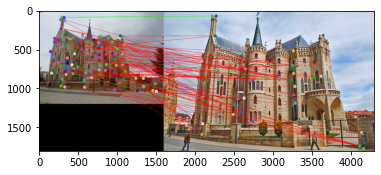

In [48]:
img1 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg'), cv2.COLOR_BGR2RGB))
img2 = im2single(cv2.cvtColor(cv2.imread('paired_data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg'), cv2.COLOR_BGR2RGB))
eval_file = 'paired_data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
img1_feats = NormalizedPatchFeatures(gray_img1, x1, y1)
img2_feats = NormalizedPatchFeatures(gray_img2, x2, y2)
matches, confidences = MatchFeatures(img1_feats, img2_feats, x1, y1, x2, y2, threshold=1.0)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(img1, img2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.show()

## SIFT like features
Steps

In [49]:
# convert one image to gray image
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

# get sobel filters
I_x = cv2.Sobel(gray_img1, cv2.CV_64F, 1, 0, ksize=3)
I_y = cv2.Sobel(gray_img1, cv2.CV_64F, 0, 1, ksize=3)

# compute angles and magnitudes of the image
angles = np.arctan2(I_y, I_x)
magnitudes = np.sqrt(I_x ** 2 + I_y ** 2)

print('maximum of angles: {0}, minimum of angles: {1}, maximum of magnitudes: {2}, minimum of magnitudes: {3}'
.format(np.max(angles), np.min(angles), np.max(magnitudes), np.min(magnitudes)))

maximum of angles: 3.141592653589793, minimum of angles: -3.141592636389609, maximum of magnitudes: 3.3401445065574142, minimum of magnitudes: 0.0


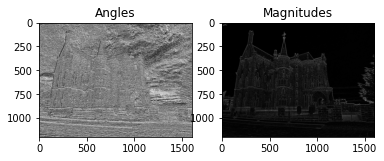

In [50]:
# plot
plt.subplot(1, 2, 1); plt.imshow(angles, cmap='gray')
plt.title('Angles')
plt.subplot(1, 2, 2); plt.imshow(magnitudes, cmap='gray')
plt.title('Magnitudes')
plt.show()

/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/4121855960.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi = int(x1[idx])
/var/folders/0y/pb3l42j12r19tq7lw5hpgl1c0000gn/T/ipykernel_89456/4121855960.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yi = int(y1[idx])


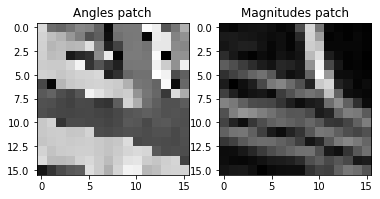

In [51]:
# any random interest point
idx = np.random.randint(x1.shape[0])

# coordinate
xi = int(x1[idx])
yi = int(y1[idx])

half_win_rng = 8

# get patch
angles_patch = angles[yi - half_win_rng : yi + half_win_rng, xi - half_win_rng : xi + half_win_rng]
magnitudes_patch = magnitudes[yi - half_win_rng : yi + half_win_rng, xi - half_win_rng : xi + half_win_rng]

# plot
plt.subplot(1, 2, 1); plt.imshow(angles_patch, cmap='gray')
plt.title('Angles patch')
plt.subplot(1, 2, 2); plt.imshow(magnitudes_patch, cmap='gray')
plt.title('Magnitudes patch')
plt.show()

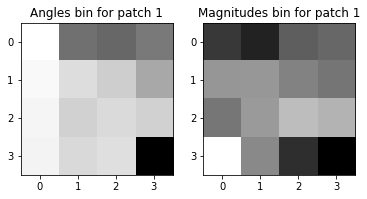

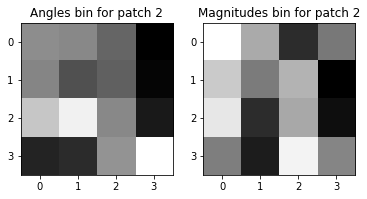

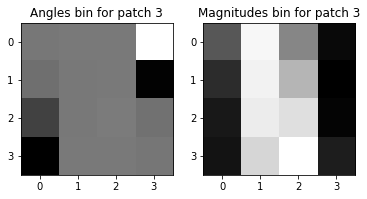

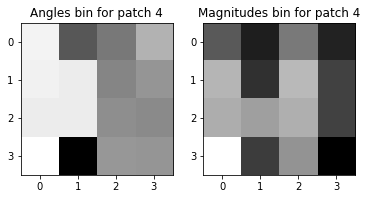

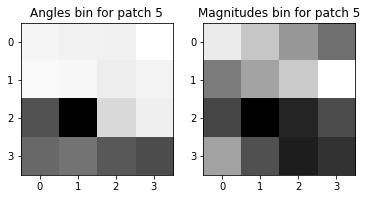

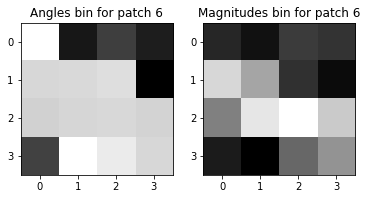

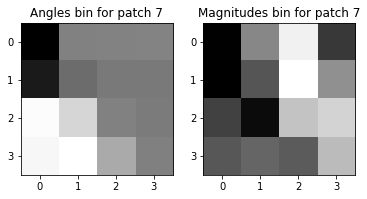

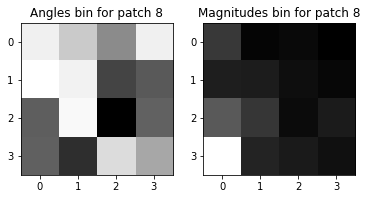

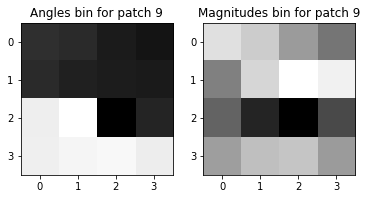

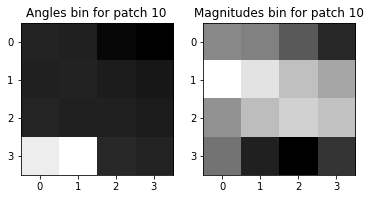

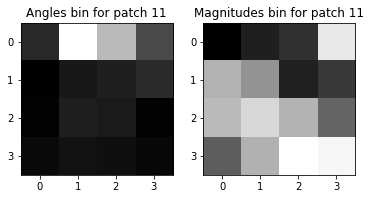

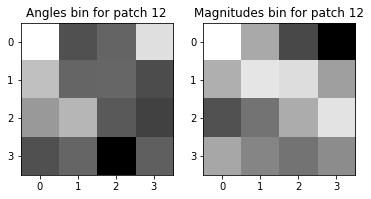

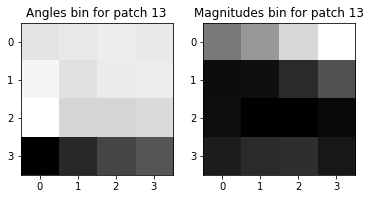

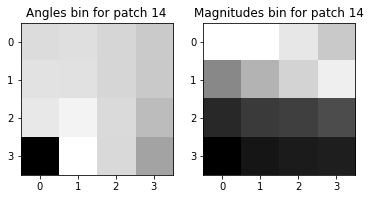

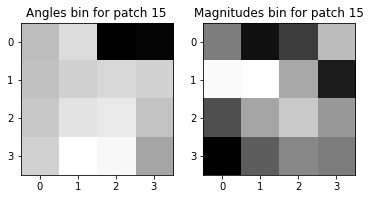

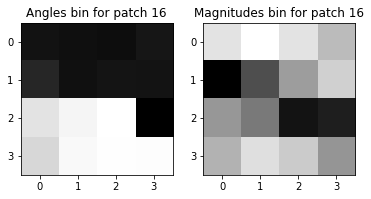

In [52]:
feature_width = 16
step = 4
count = 1
for j in range(0, feature_width, step):
    for k in range(0, feature_width, step):
        # get bins for each patch
        angles_patch_bin = angles_patch[j : j + 4, k : k + 4]
        magnitudes_patch_bin = magnitudes_patch[j : j + 4, k : k + 4]
        # plot
        plt.subplot(1, 2, 1); plt.imshow(angles_patch_bin, cmap='gray')
        plt.title('Angles bin for patch ' + str(count))
        plt.subplot(1, 2, 2); plt.imshow(magnitudes_patch_bin, cmap='gray')
        plt.title('Magnitudes bin for patch ' + str(count))
        plt.show()
        count += 1